In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


In [44]:
def dick_fuller(dataset):
    test = adfuller(dataset, autolag='AIC')
    print("[!] - ADF:", test[0])
    print("[!] - p_value:", test[1])
    print("[*] - State of time-series: ", 'stationary' if test[1] < 0.05 else 'non-stationary')
    print("[!] - Lags:", test[2])

In [3]:
hue_data = pd.read_csv('data/HUE/1hour/Residential_1.csv', parse_dates=True).sort_values(by=['date', 'hour'])

In [4]:
print(hue_data.shape)
print(hue_data.describe().transpose())
hue_data.date = pd.to_datetime(hue_data.date) + pd.to_timedelta(hue_data.pop('hour'), unit='h')
hue_data.index = hue_data.pop('date')

(29231, 3)
              count       mean       std  min    25%     50%     75%     max
hour        29231.0  11.508878  6.918596  0.0  6.000  12.000  18.000  23.000
energy_kWh  29231.0   1.105084  0.686967  0.0  0.607   0.884   1.358  12.372


In [5]:
hue_data

,energy_kWh
date,
2012-06-01 01:00:00,1.011
2012-06-01 02:00:00,0.451
2012-06-01 03:00:00,0.505
2012-06-01 04:00:00,0.441
2012-06-01 05:00:00,0.468
...,...
2015-10-02 20:00:00,2.101
2015-10-02 21:00:00,1.646
2015-10-02 22:00:00,1.319


In [48]:
dick_fuller(hue_data['energy_kWh'])
#if stationary, d=0

[!] - ADF: -12.581675667012943
[!] - p_value: 1.904397020759028e-23
[*] - State of time-series:  stationary
[!] - Lags: 47


In [45]:
daily_hue_data = hue_data.resample('D').sum()

In [46]:
df = daily_hue_data

In [47]:
dick_fuller(df['energy_kWh'])

[!] - ADF: -3.6087095010631574
[!] - p_value: 0.005596687256890635
[*] - State of time-series:  stationary
[!] - Lags: 13


/Users/paulovitorbarbosaramos/opt/anaconda3/envs/consumption-forecasting/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


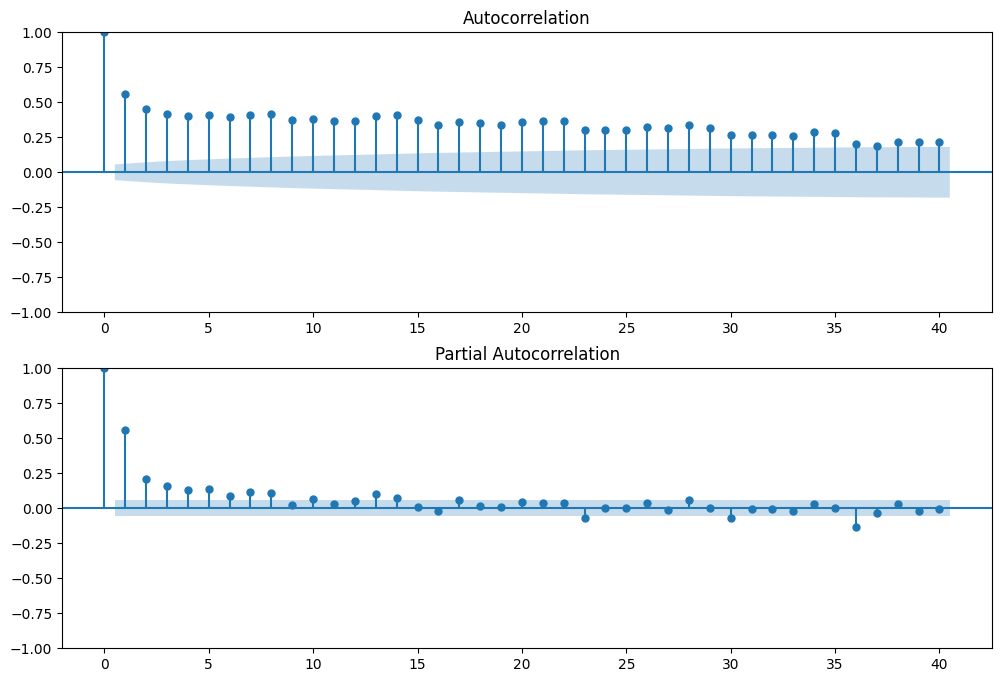

In [72]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['energy_kWh'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['energy_kWh'], lags=40, ax=ax2)

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
energy_kWh,1220.0,26.477623,5.894293,0.8,22.3815,25.7995,30.1145,47.329


In [11]:
n_features = len(df)
train_df = df[:int(n_features*0.7)]
test_df = df[int(n_features*0.7):]
print(train_df.shape, test_df.shape)

(854, 1) (366, 1)


In [12]:
print(train_df.tail(1), test_df.tail(1))

            energy_kWh
date                  
2014-10-02      23.045             energy_kWh
date                  
2015-10-03         0.8


In [13]:
test_df, train_df

(            energy_kWh
 date                  
 2014-10-03      20.673
 2014-10-04      19.815
 2014-10-05      24.460
 2014-10-06      28.627
 2014-10-07      24.239
 ...                ...
 2015-09-29      26.975
 2015-09-30      23.496
 2015-10-01      23.884
 2015-10-02      29.384
 2015-10-03       0.800
 
 [366 rows x 1 columns],
             energy_kWh
 date                  
 2012-06-01      19.476
 2012-06-02      20.331
 2012-06-03      22.844
 2012-06-04      25.610
 2012-06-05      24.127
 ...                ...
 2014-09-28      29.603
 2014-09-29      24.149
 2014-09-30      18.490
 2014-10-01      19.978
 2014-10-02      23.045
 
 [854 rows x 1 columns])

In [69]:
model = auto_arima(df['energy_kWh'], 
                   test='adf',
                   trace=True, 
                   supress_warning=True)
model.fit(train_df['energy_kWh'])
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7793.732, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7335.552, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7498.465, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11517.344, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=7284.593, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7256.783, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=7238.673, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=7219.183, Time=0.21 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=7168.920, Time=0.94 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7168.320, Time=0.74 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7167.712, Time=0.72 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7162.540, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7201.081, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  854
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2475.771
Date:                Thu, 08 Sep 2022   AIC                           4961.542
Time:                        11:13:31   BIC                           4985.291
Sample:                    06-01-2012   HQIC                          4970.637
                         - 10-02-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2452      0.137      1.789      0.074      -0.023       0.514
ar.L1          1.1910      0.042     28.244      0.000       1.108       1.274
ar.L2         -0.2007      0.040     -5.006      0.000      -0.279      -0.122
ma.L1         -0.8814      0.023    -38.870      0.000      -0.926      -0.837
sigma2        19.3636      0.805     24.053      0.000      17.786      20.941
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.61
Prob(H) (two-sided):                  0.84   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

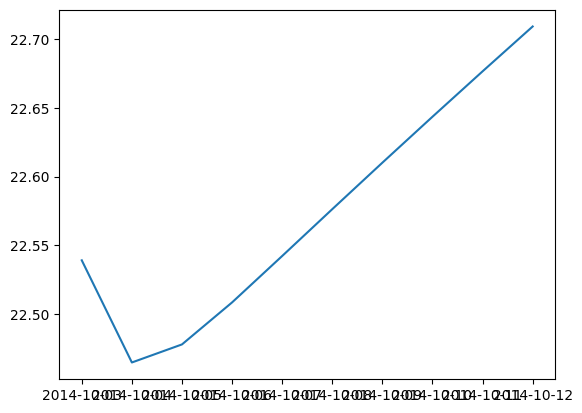

In [82]:
plt.plot(model.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels'))


In [70]:
arima_model = ARIMA(df['energy_kWh'], order=(5,0,8))
arima_model = arima_model.fit()
arima_model.summary()


/Users/paulovitorbarbosaramos/opt/anaconda3/envs/consumption-forecasting/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             energy_kWh   No. Observations:                 1220
Model:                 ARIMA(5, 0, 8)   Log Likelihood               -3570.619
Date:                Thu, 08 Sep 2022   AIC                           7171.239
Time:                        11:13:52   BIC                           7247.838
Sample:                    06-01-2012   HQIC                          7200.069
                         - 10-03-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8509      1.449     17.844      0.000      23.011      28.690
ar.L1          0.6929      0.230      3.014      0.003       0.242       1.143
ar.L2         -0.6669      0.229     -2.908      0.004      -1.116      -0.217
ar.L3          0.7758      0.127      6.097      0.000       0.526       1.025
ar.L4         -0.5089      0.198     -2.576      0.010      -0.896      -0.122
ar.L5          0.6650      0.171      3.883      0.000       0.329       1.001
ma.L1         -0.3751      0.228     -1.642      0.101      -0.823       0.073
ma.L2          0.6206      0.195      3.183      0.001       0.238       1.003
ma.L3         -0.5625      0.113     -4.977      0.000      -0.784      -0.341
ma.L4          0.3997      0.178      2.245      0.025       0.051       0.749
ma.L5         -0.5164      0.137     -3.770      0.000      -0.785      -0.248
ma.L6         -0.1515      0.048     -3.168      0.002      -0.245      -0.058
ma.L7          0.0131      0.045      0.290      0.772      -0.076       0.102
ma.L8          0.0175      0.042      0.419      0.675      -0.064       0.100
sigma2        20.4574      0.642     31.864      0.000      19.199      21.716
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               219.38
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.30
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

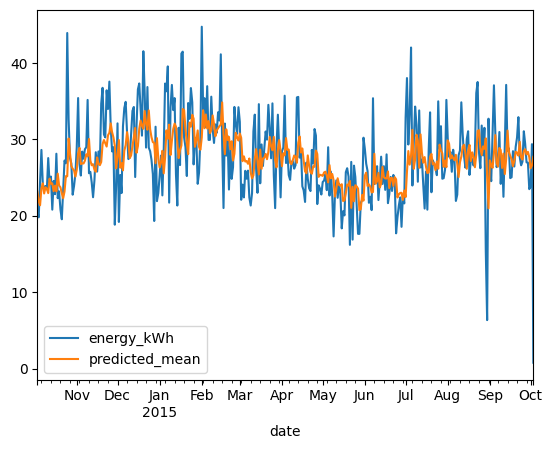

In [71]:
preds = arima_model.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')
test_df['energy_kWh'].plot(legend=True)
preds.plot(legend=True)

In [77]:
resid = model.resid
resid

<bound method ARIMA.resid of ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)>

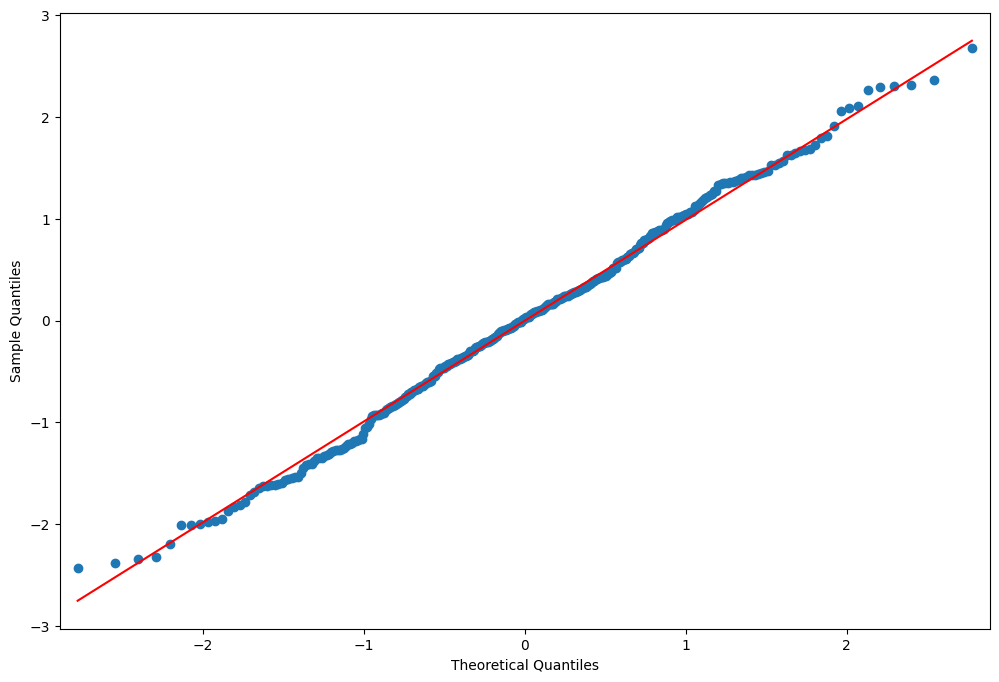

In [81]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(preds, line="q", ax=ax, fit=True)